# TensroFlow Quantum でQCL

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

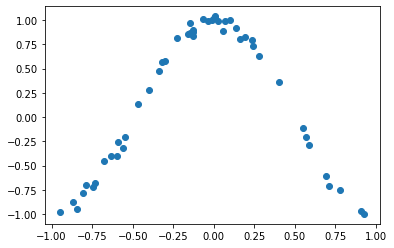

In [2]:
########  パラメータ  #############
nqubit = 3 ## qubitの数
c_depth = 3 ## circuitの深さ
time_step = 0.77  ## ランダムハミルトニアンによる時間発展の経過時間

## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 50

## 学習したい1変数関数
func_to_learn = lambda x: np.cos(x*np.pi)

## 乱数のシード
random_seed = 2
## 乱数発生器の初期化
np.random.seed(random_seed)

#### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

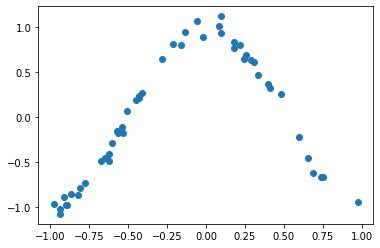

In [3]:
#### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

## 入力状態の作成

In [47]:
def convert_to_circuit(x):
    """Encode truncated classical image into quantum datapoint."""
    y = np.arcsin(x)
    z = np.arccos(x**2)
    qubits = cirq.GridQubit.rect(5, 1)
    circuit = cirq.Circuit()
    for i in range(5):
        circuit.append(cirq.ry(y).on(qubits[i]))
        circuit.append(cirq.rz(z).on(qubits[i]))
    return circuit


In [48]:
x_train_circ = [convert_to_circuit(x) for x in x_train]

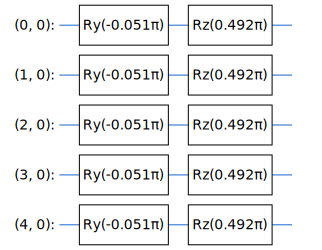

In [49]:
SVGCircuit(x_train_circ[0])

In [51]:
x_train[0],np.arcsin(x_train[0])/np.pi

(-0.16052907738635858, -0.051320039381280984)

In [52]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)

## パラメトリック量子回路（ニューラルネット）の作成

In [60]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)
            
    def add_layer_single(self,circuit,gate,prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(symbol).on(qubit))
    
    def add_entangler(self,circuit,len_qubit):
        for i in range(len_qubit):
            circuit.append(cirq.CZ(self.data_qubits[i],self.data_qubits[(i+1)%len_qubit]))

In [66]:
def create_quantum_model(c_depth=3):
    data_qubits = cirq.GridQubit.rect(5,1)
    readout = cirq.GridQubit(1,1)
    circuit = cirq.Circuit()
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout = readout
    )
    
    for i in range(3):
        builder.add_entangler(circuit,5)
        builder.add_layer_single(circuit,cirq.rx,"rx"+str(i))
    
    return circuit, cirq.Z(readout)

In [67]:
model_circuit, model_readout = create_quantum_model()

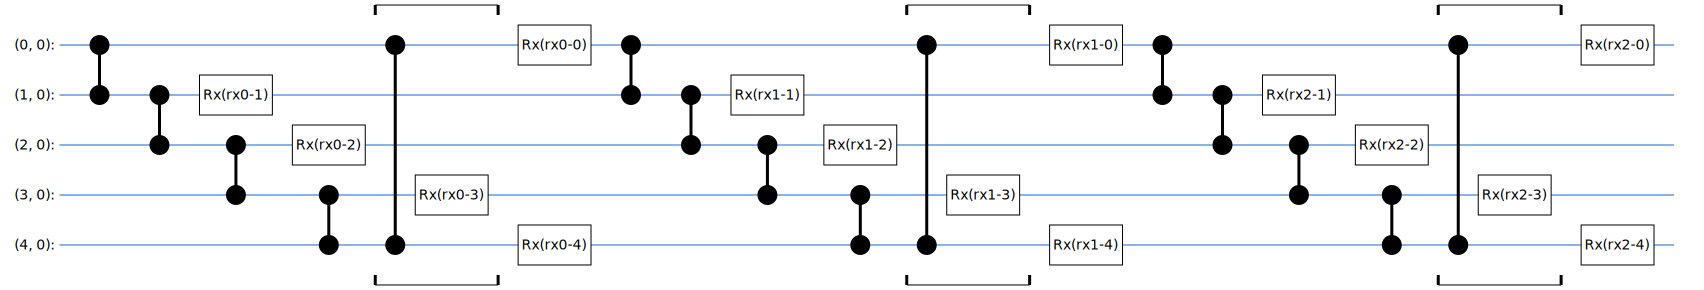

In [68]:
SVGCircuit(model_circuit)

In [82]:
model_readout

cirq.Z.on(cirq.GridQubit(1, 1))

In [70]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [84]:
model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae'])

In [85]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
EPOCHS = 3
BATCH_SIZE = 32

In [87]:
qnn_history = model.fit(
      x_train_tfcirc, y_train,
      batch_size=16,
      epochs=EPOCHS,
      verbose=1,
)

Train on 50 samples
Epoch 1/3
16/50 [========>.....................] - ETA: 1s

InvalidArgumentError:  Found a Pauli sum operating on qubits not found in circuit.
	 [[node sequential/pqc/expectation/TfqSimulateExpectation (defined at <string>:69) ]] [Op:__inference_distributed_function_2028]

Errors may have originated from an input operation.
Input Source operations connected to node sequential/pqc/expectation/TfqSimulateExpectation:
 sequential/pqc/Tile_1 (defined at /home/sakai2030/anaconda3/envs/tf-q/lib/python3.6/site-packages/tensorflow_quantum/python/layers/high_level/pqc.py:269)	
 sequential/pqc/expectation/1859 (defined at /home/sakai2030/anaconda3/envs/tf-q/lib/python3.6/site-packages/tensorflow_quantum/python/layers/circuit_executors/expectation.py:354)	
 sequential/pqc/Tile_2 (defined at /home/sakai2030/anaconda3/envs/tf-q/lib/python3.6/site-packages/tensorflow_quantum/python/layers/high_level/pqc.py:270)	
 sequential/pqc/add_circuit/TfqAppendCircuit (defined at <string>:63)

Function call stack:
distributed_function
